In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
pd.options.mode.chained_assignment = None

from sklearn import preprocessing

from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import pprint

%matplotlib inline

In [56]:
df = pd.read_csv("3355.csv")

###Condensing dataframe down to features to explore

In [57]:
df2 = df[[
'CASENUM','YEAROB1','SEX','RACE','ETHNIC', 
'ADTYP','RELTYP','NFRCTNS',
'DRUGTRT','ALCTRT','SEXTRT','EDUCAT','VOCAT',
'SMPOFF5','RELAGE','SNTLN','TMSRV','PCTSRV',
'A001CNT', 'A001YR','A001MO','A001ST','A001FM1', 'A001OFF1',
'J001MO', 'J001YR', 'J001CNT', 'J001OFF1', 'J001FM1', 'J001CNV1', 'J001CNF1', 'J001PJP1', 'J001PMX1', 'J001PRB1',
'REARR','ROTST','PRIR','POTST']]
df2.head()

,CASENUM,YEAROB1,SEX,RACE,ETHNIC,ADTYP,RELTYP,NFRCTNS,DRUGTRT,ALCTRT,...,J001FM1,J001CNV1,J001CNF1,J001PJP1,J001PMX1,J001PRB1,REARR,ROTST,PRIR,POTST
0,1,1932,MALE,WHITE,HISPANIC,"MANDATORY PAROLE RELEASE REVOCATION, NO NEW SE...",OTHER UNCONDITIONAL RELEASE,INMATE HAS RECORD,UNKNOWN,UNKNOWN,...,MISDEMEANOR,CONVICTED,CONFINED,JAIL,0.66,99899899.9,4,0,93,0
1,2,1929,MALE,WHITE,HISPANIC,COURT COMMITMENT,OTHER CONDITIONAL RELEASE,NO RECORD,UNKNOWN,UNKNOWN,...,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,99899899.90,99899899.9,1,0,30,0
2,3,1934,MALE,WHITE,HISPANIC,COURT COMMITMENT,PAROLE BOARD DECISION-SERVED NO MINIMUM,INMATE HAS RECORD,UNKNOWN,UNKNOWN,...,FELONY,CONVICTED,CONFINED,PRISON,60.00,1000000.0,1,0,9,6
3,4,1931,MALE,BLACK,NON-HISPANIC,"MANDATORY PAROLE RELEASE REVOCATION, NO NEW SE...",OTHER UNCONDITIONAL RELEASE,NO RECORD,UNKNOWN,UNKNOWN,...,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,1000000.00,1000000.0,888,888,888,888
4,5,1942,MALE,WHITE,NON-HISPANIC,"MANDATORY PAROLE RELEASE REVOCATION, NO NEW SE...",EXPIRATION OF SENTENCE,NO RECORD,UNKNOWN,UNKNOWN,...,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,99899899.90,99899899.9,1,0,3,0


###Replacing unknown numeric values with nan (for now)

In [58]:
df2['YEAROB1'] = df2['YEAROB1'].replace(9999,np.nan)
df2['A001YR'] = df2['A001YR'].replace(9999,np.nan)
df2['A001YR'] = df2['A001YR'].replace(9998,np.nan)
df2['REARR'] = df2['REARR'].replace(888,np.nan)
df2['ROTST'] = df2['ROTST'].replace(888,np.nan)
df2['PRIR'] = df2['PRIR'].replace(888,np.nan)
df2['POTST'] = df2['POTST'].replace(888,np.nan)
df2['RELAGE'] = df2['RELAGE'].replace(99999999.99,np.nan)
df2['RELAGE'] = df2['RELAGE'].replace(100000000.00,np.nan)
df2['TMSRV'] = df2['TMSRV'].replace(99899899.88,np.nan)
df2['TMSRV'] = df2['TMSRV'].replace(998999.00,np.nan)
df2['SNTLN'] = df2['SNTLN'].replace(99899899.88,np.nan)
df2['SNTLN'] = df2['SNTLN'].replace(998999.00,np.nan)
df2['PCTSRV'] = df2['PCTSRV'].replace(99899899.88,np.nan)
df2['PCTSRV'] = df2['PCTSRV'].replace(998999.00,np.nan)
df2['A001CNT'] = df2['A001CNT'].replace(99,np.nan)
df2['A001CNT'] = df2['A001CNT'].replace(98,np.nan)
df2['J001YR'] = df2['J001YR'].replace(9999,np.nan)

###Adding calculated features

In [59]:
df2['AGE_FIRST_OFF'] = df2.A001YR - df2.YEAROB1
df2['AGE_FIRST_OFF'][df2['AGE_FIRST_OFF'] < 16] = np.nan
df2['TOT_PRARR'] = (df2['PRIR'] + df2['POTST'])
df2['CAREER_LEN'] = df2.RELAGE-df2.AGE_FIRST_OFF
df2['SNTLN_YRS'] = df2.SNTLN/12
df2['TOTREARR'] = df2.REARR + df2.ROTST
df2['AVG_YRLY_ARR'] = df2.TOT_PRARR/df2.CAREER_LEN
df2['AVG_YRLY_ARR'][df2['AVG_YRLY_ARR'] < 0] = np.nan
df2['AVG_YRLY_ARR'][df2['AVG_YRLY_ARR'] > 100] = 0
df2['RESP'] = 0
df2['RESP'][df2['TOTREARR'] > 0] = 1

In [60]:
treatments = ['DRUGTRT', 'ALCTRT', 'SEXTRT', 'EDUCAT', 'VOCAT']

for x in treatments:
    df2[x] = df2[x].replace('UNKNOWN',0)
    df2[x] = df2[x].replace('INMATE DID NOT PARTICIPATE',0)
    df2[x] = df2[x].replace('INMATE PARTICIPATED BUT UNKNOWN IF COMPLETED',1)
    df2[x] = df2[x].replace('INMATE PARTICIPATED IN PROGRAM & COMPLETED IT',1)
    df2[x] = df2[x].replace('INMATE PARTICIPATED BUT DID NOT COMPLETE',1)

df2['TREATMENT'] = df2.DRUGTRT + df2.ALCTRT + df2.SEXTRT + df2.EDUCAT + df2.VOCAT
for x in treatments:
    df2.drop(x, axis=1, inplace=True)
df2['TREATMENT'][df2['TREATMENT'] > 0] = 1

###Counting nan percentage

In [61]:
features = df2.columns.values.tolist()

In [62]:
for feature in features:
    per = float(float(len(df2[feature]) - df2[feature].count())/len(df2[feature]))
    if per > 0.0:
        print feature, "has %0.2f percent missing values" % (per*100)

YEAROB1 has 0.03 percent missing values
RELAGE has 0.13 percent missing values
TMSRV has 12.50 percent missing values
PCTSRV has 18.14 percent missing values
A001CNT has 3.18 percent missing values
A001YR has 2.55 percent missing values
J001YR has 15.24 percent missing values
REARR has 2.53 percent missing values
ROTST has 18.88 percent missing values
PRIR has 12.50 percent missing values
POTST has 12.50 percent missing values
AGE_FIRST_OFF has 5.48 percent missing values
TOT_PRARR has 12.50 percent missing values
CAREER_LEN has 5.48 percent missing values
TOTREARR has 18.88 percent missing values
AVG_YRLY_ARR has 16.11 percent missing values


###Cleaning up missing data

In [63]:
#Hard coded the mode of the ROTST & POTST column
df2['ROTST']= df2.ROTST.replace(np.nan,0)
df2['POTST']= df2.POTST.replace(np.nan,0)

In [64]:
df2['PRIR'] = df2.PRIR.replace(np.nan,df2.PRIR.mean())
df2['REARR'] = df2.REARR.replace(np.nan,df2.REARR.mean())
df2['PCTSRV'] = df2.PCTSRV.replace(np.nan,df2.PCTSRV.mean())
df2['TMSRV'] = df2.TMSRV.replace(np.nan,df2.TMSRV.mean())

###Recalculate features with cleaned data

In [65]:
df2['AGE_FIRST_OFF'] = df2.A001YR - df2.YEAROB1
df2['AGE_FIRST_OFF'][df2['AGE_FIRST_OFF'] < 16] = np.nan
df2['TOT_PRARR'] = (df2['PRIR'] + df2['POTST'])
df2['CAREER_LEN'] = df2.RELAGE-df2.AGE_FIRST_OFF
df2['SNTLN_YRS'] = df2.SNTLN/12
df2['TOTREARR'] = df2.REARR + df2.ROTST
df2['AVG_YRLY_ARR'] = df2.TOT_PRARR/df2.CAREER_LEN
df2['AVG_YRLY_ARR'][df2['AVG_YRLY_ARR'] < 0] = np.nan
df2['AVG_YRLY_ARR'][df2['AVG_YRLY_ARR'] > 100] = 0
df2['RESP'] = 0
df2['RESP'][df2['TOTREARR'] > 0] = 1

###Recheck for missing values

In [66]:
for feature in features:
    per = float(float(len(df2[feature]) - df2[feature].count())/len(df2[feature]))
    if per > 0.0:
        print feature, "has %0.2f percent missing values" % (per*100)

YEAROB1 has 0.03 percent missing values
RELAGE has 0.13 percent missing values
A001CNT has 3.18 percent missing values
A001YR has 2.55 percent missing values
J001YR has 15.24 percent missing values
AGE_FIRST_OFF has 5.48 percent missing values
CAREER_LEN has 5.48 percent missing values
AVG_YRLY_ARR has 6.32 percent missing values


###Look at means for each group to be classified

In [67]:
df2.groupby('RESP').mean()

,CASENUM,YEAROB1,RELAGE,SNTLN,TMSRV,PCTSRV,A001CNT,A001YR,J001YR,J001CNT,...,ROTST,PRIR,POTST,AGE_FIRST_OFF,TOT_PRARR,CAREER_LEN,SNTLN_YRS,TOTREARR,AVG_YRLY_ARR,TREATMENT
RESP,,,,,,,,,,,,,,,,,,,,,
0,1646.699693,1958.202407,35.834532,71.708477,30.69262,7.189998e+07,1.512116,1983.049657,4991.074572,33.182199,...,0.000000,4.886224,0.792492,25.061670,5.678716,10.799303,5.975706,0.00000,0.697535,0.208358
1,1615.692796,1962.324688,31.672924,59.240011,24.63484,1.175770e+08,1.494569,1983.205909,5278.597988,38.035143,...,0.231646,8.537807,1.027215,21.094002,9.565022,10.559618,4.936668,2.88075,1.082008,0.226375


###Quick visualize distribution of features

In [68]:
def make_plot(x):
    plt.figure(figsize = (15,5))
    sns.countplot(sorted(df2[x]))
    plt.xticks(rotation = 90)
    plt.xlabel(x)
    plt.show()

#for feature in features:
#    make_plot(feature)

###Set up selected features, train/test split and scale

In [69]:
y, X = dmatrices('RESP ~ ADTYP + np.log(A001CNT+1) + SEX + RACE  + ETHNIC +RELTYP + J001PJP1+ np.log(RELAGE+1) + np.log(TMSRV+1) + np.log(TOT_PRARR+1) + PCTSRV + np.log(AGE_FIRST_OFF) + SMPOFF5+ A001FM1 + C(TREATMENT) + SNTLN_YRS + np.log(AVG_YRLY_ARR + 1)', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

###Baseline predictor


In [70]:
def always_reoffend(x):
    return [1] * len(x)
y_pred = always_reoffend(x_test)

print "Baseline = %0.2f" % accuracy_score(y_test, y_pred) 

Baseline = 0.58


###Train model and evaluate test accuracy

In [71]:
def test_model(name, main_model):
    model = main_model
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print name, "test accuracy score:", accuracy_score(y_test, model.predict(x_test))
    
test_model("KNN", KNeighborsClassifier())
test_model("Logistic Regression", LogisticRegression())
test_model("Gaussian Naive Bayes", GaussianNB())
test_model("SVM Classifier", SVC())
test_model("Decision Tree", DecisionTreeClassifier())
test_model("Random Forest", RandomForestClassifier())

KNN test accuracy score: 0.65709835336
Logistic Regression test accuracy score: 0.695705384958
Gaussian Naive Bayes test accuracy score: 0.599577214063
SVM Classifier test accuracy score: 0.697930574099
Decision Tree test accuracy score: 0.614485981308
Random Forest test accuracy score: 0.661659991099


###Look at feature importance

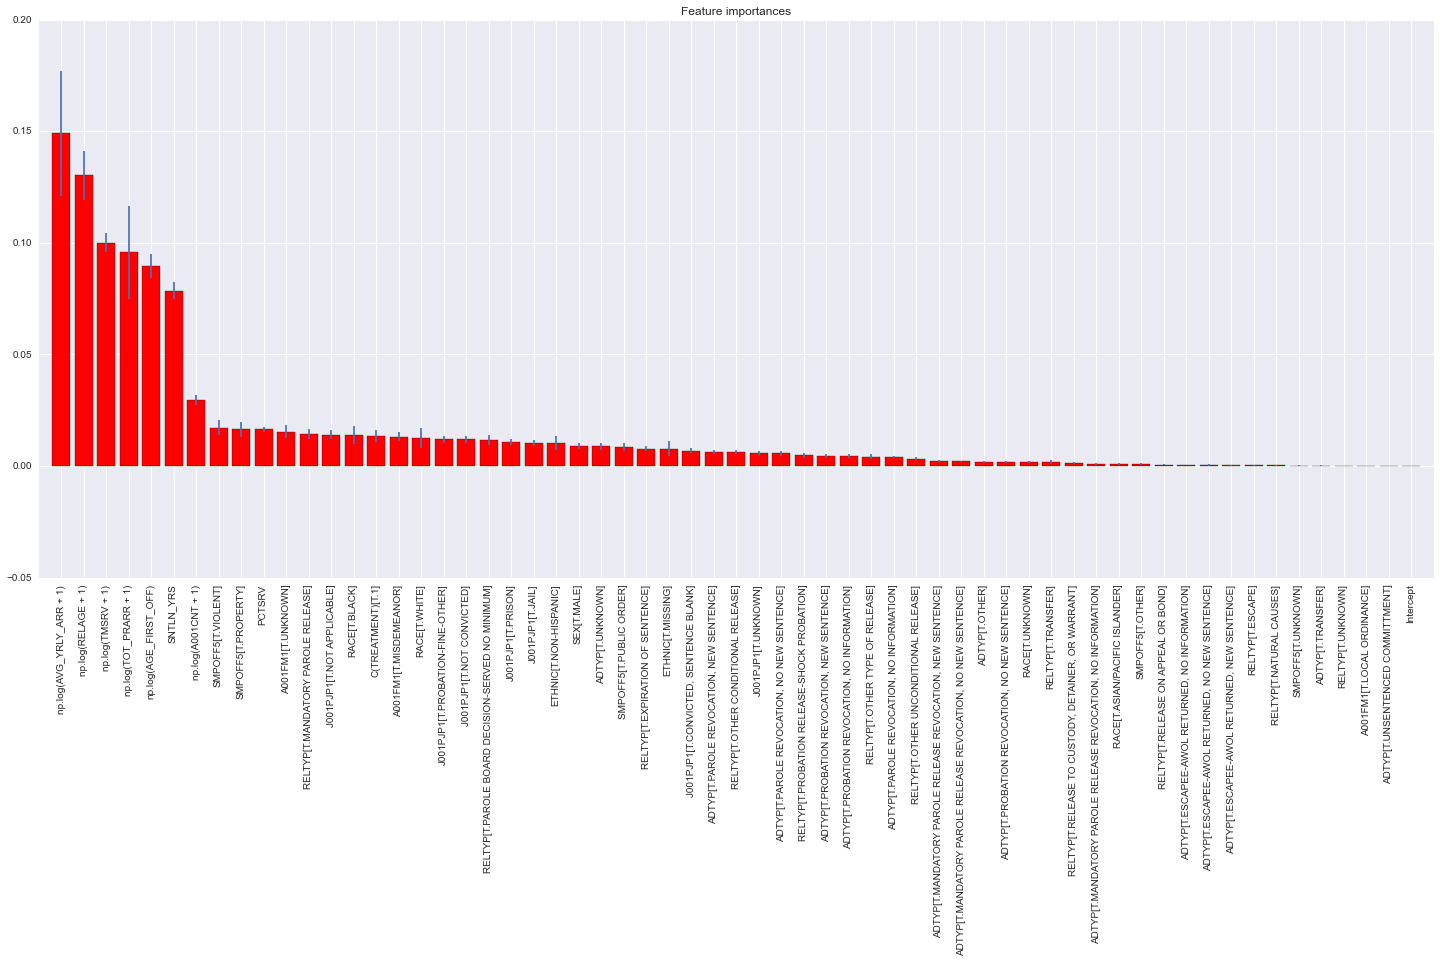

In [72]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (25,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation = 90)
plt.xlim([-1, len(indices)])
plt.show()

###Create dataframe with confusion matrix metrics for each feature in model

In [73]:
cm_features = ['AVG_YRLY_ARR','RELAGE','TOT_PRARR', 'TMSRV', 'AGE_FIRST_OFF','SNTLN_YRS', 'SMPOFF5','J001PJP1']

In [74]:
model_list = []
for feature in cm_features:
    model = "y, X = dmatrices('RESP ~ " +feature+ "', data=df2, return_type='dataframe')"
    model_list.append(model)
pprint.pprint(model_list)

["y, X = dmatrices('RESP ~ AVG_YRLY_ARR', data=df2, return_type='dataframe')",
 "y, X = dmatrices('RESP ~ RELAGE', data=df2, return_type='dataframe')",
 "y, X = dmatrices('RESP ~ TOT_PRARR', data=df2, return_type='dataframe')",
 "y, X = dmatrices('RESP ~ TMSRV', data=df2, return_type='dataframe')",
 "y, X = dmatrices('RESP ~ AGE_FIRST_OFF', data=df2, return_type='dataframe')",
 "y, X = dmatrices('RESP ~ SNTLN_YRS', data=df2, return_type='dataframe')",
 "y, X = dmatrices('RESP ~ SMPOFF5', data=df2, return_type='dataframe')",
 "y, X = dmatrices('RESP ~ J001PJP1', data=df2, return_type='dataframe')"]


In [75]:
y, X = dmatrices('RESP ~ ADTYP + np.log(A001CNT+1) + SEX + RACE  + ETHNIC +RELTYP + J001PJP1+ np.log(RELAGE+1) + np.log(TMSRV+1) + np.log(TOT_PRARR+1) + PCTSRV + np.log(AGE_FIRST_OFF) + SMPOFF5+ A001FM1 + C(TREATMENT) + SNTLN_YRS + np.log(AVG_YRLY_ARR + 1)', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [76]:
cm = confusion_matrix(y_test, model.predict(x_test))

In [77]:
cm_df = pd.DataFrame(np.hstack((cm[0],cm[1])))
cm_df

,0
0,1845
1,1908
2,807
3,4428


In [78]:
y, X = dmatrices('RESP ~ TMSRV', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['TMSRV'] = np.hstack((cm[0],cm[1]))

In [79]:
y, X = dmatrices('RESP ~ RELAGE', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['RELAGE'] = np.hstack((cm[0],cm[1]))

In [80]:
y, X = dmatrices('RESP ~ SNTLN_YRS', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['SNTLN_YRS'] = np.hstack((cm[0],cm[1]))

In [81]:
y, X = dmatrices('RESP ~ SMPOFF5', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['SMPOFF5'] = np.hstack((cm[0],cm[1]))

In [82]:
y, X = dmatrices('RESP ~ A001CNT', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['A001CNT'] = np.hstack((cm[0],cm[1]))

In [83]:
y, X = dmatrices('RESP ~ J001PJP1', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['J001PJP1'] = np.hstack((cm[0],cm[1]))

In [84]:
y, X = dmatrices('RESP ~ TOT_PRARR', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['TOT_PRARR'] = np.hstack((cm[0],cm[1]))

In [85]:
y, X = dmatrices('RESP ~ AVG_YRLY_ARR', data=df2, return_type='dataframe')
y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['AVG_YRLY_ARR'] = np.hstack((cm[0],cm[1]))

In [86]:
y, X = dmatrices('RESP ~ AGE_FIRST_OFF', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, model.predict(x_test))
cm_df['AGE_FIRST_OFF'] = np.hstack((cm[0],cm[1]))

In [87]:
cm_df.columns =['Full model', 'Time served (1994)', 'Age at release (1994)' , 'Sentence Length (1994)','Severity of offense (1994)', 'Number of arrests', 'Consequence (first arrest)', 'Total prior arrests (1994)','Average arrest rate','Age at first offense',]
cm_df =cm_df[['Full model', 'Time served (1994)', 'Age at release (1994)' , 'Sentence Length (1994)','Severity of offense (1994)','Consequence (first arrest)', 'Total prior arrests (1994)','Average arrest rate', 'Age at first offense']]
cm_df

,Full model,Time served (1994),Age at release (1994),Sentence Length (1994),Severity of offense (1994),Consequence (first arrest),Total prior arrests (1994),Average arrest rate,Age at first offense
0,1845,461,786,154,6,846,1135,1462,1140
1,1908,3327,2991,3634,3782,2942,2653,2299,2671
2,807,383,467,153,3,686,610,810,614
3,4428,5485,5400,5715,5865,5182,5258,4475,4702


In [88]:
cm_plot_df = cm_df.T
cm_plot_df

,0,1,2,3
Full model,1845,1908,807,4428
Time served (1994),461,3327,383,5485
Age at release (1994),786,2991,467,5400
Sentence Length (1994),154,3634,153,5715
Severity of offense (1994),6,3782,3,5865
Consequence (first arrest),846,2942,686,5182
Total prior arrests (1994),1135,2653,610,5258
Average arrest rate,1462,2299,810,4475
Age at first offense,1140,2671,614,4702


In [89]:
cm_plot_df['Correct']= cm_plot_df[0] + cm_plot_df[3]
cm_plot_df['Incorrect']= cm_plot_df[1] + cm_plot_df[2]
cm_plot_df['Type 1']= cm_plot_df[1]
cm_plot_df['Type 2']= cm_plot_df[2]
cm_plot_df = cm_plot_df[['Correct', 'Incorrect','Type 1','Type 2']]
cm_plot_df

,Correct,Incorrect,Type 1,Type 2
Full model,6273,2715,1908,807
Time served (1994),5946,3710,3327,383
Age at release (1994),6186,3458,2991,467
Sentence Length (1994),5869,3787,3634,153
Severity of offense (1994),5871,3785,3782,3
Consequence (first arrest),6028,3628,2942,686
Total prior arrests (1994),6393,3263,2653,610
Average arrest rate,5937,3109,2299,810
Age at first offense,5842,3285,2671,614


In [90]:
per_plot_df = cm_plot_df.copy()
per_plot_df['TOTAL'] = per_plot_df['Correct'] + per_plot_df['Incorrect']
per_plot_df['Correct'] = per_plot_df['Correct']/per_plot_df['TOTAL']
per_plot_df['Incorrect'] = per_plot_df['Incorrect']/per_plot_df['TOTAL']
per_plot_df = per_plot_df[['Correct', 'Incorrect']]
per_plot_df = per_plot_df.sort(['Correct'], ascending = False)
per_plot_df

,Correct,Incorrect
Full model,0.697931,0.302069
Total prior arrests (1994),0.662075,0.337925
Average arrest rate,0.656312,0.343688
Age at release (1994),0.641435,0.358565
Age at first offense,0.640079,0.359921
Consequence (first arrest),0.624275,0.375725
Time served (1994),0.615783,0.384217
Severity of offense (1994),0.608016,0.391984
Sentence Length (1994),0.607809,0.392191


In [91]:
per_plot_df.to_csv('final_data.csv', sep=',', header = ['Correct', 'Incorrect'])

In [92]:
in_per_plot_df = cm_plot_df.copy()
in_per_plot_df['TOTAL'] = in_per_plot_df['Correct'] + in_per_plot_df['Incorrect']
in_per_plot_df['Type 1'] = in_per_plot_df['Type 1']/in_per_plot_df['TOTAL']
in_per_plot_df['Type 2'] = in_per_plot_df['Type 2']/in_per_plot_df['TOTAL']
in_per_plot_df = in_per_plot_df[['Type 1', 'Type 2']]
in_per_plot_df = in_per_plot_df.sort(['Type 1'], ascending = False)
in_per_plot_df

,Type 1,Type 2
Severity of offense (1994),0.391674,0.000311
Sentence Length (1994),0.376346,0.015845
Time served (1994),0.344553,0.039664
Age at release (1994),0.310141,0.048424
Consequence (first arrest),0.304681,0.071044
Age at first offense,0.292648,0.067273
Total prior arrests (1994),0.274751,0.063173
Average arrest rate,0.254145,0.089542
Full model,0.212283,0.089786


In [93]:
in_per_plot_df.to_csv('error_data.csv', sep=',', header = ['Innocent - presumed guilty', 'Guilty - presumed innocent'])

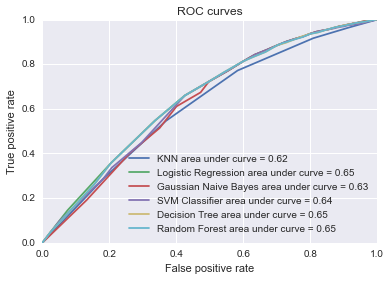

In [95]:
from sklearn.metrics import roc_auc_score
def curves(name, classifier):
    probas_ = classifier.fit(x_train, y_train).predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = "%s area under curve = %0.2f" 
             % (name, roc_auc_score(y_test, probas_[:, 1])))
    plt.legend(loc = "best")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title("ROC curves")
    
curves("KNN", KNeighborsClassifier())
curves("Logistic Regression", LogisticRegression())
curves("Gaussian Naive Bayes", GaussianNB())
curves("SVM Classifier", SVC(probability = True))
curves("Decision Tree", DecisionTreeClassifier())
curves("Random Forest", RandomForestClassifier())

###Grid search for best parameters for SVC

In [ ]:
"""y, X = dmatrices('RESP ~ ADTYP + np.log(A001CNT+1) + SEX + RACE  + ETHNIC +RELTYP + J001PJP1+ np.log(RELAGE+1) + np.log(TMSRV+1) + np.log(TOT_PRARR+1) + PCTSRV + np.log(AGE_FIRST_OFF) + SMPOFF5+ A001FM1 + C(TREATMENT) + SNTLN_YRS + np.log(AVG_YRLY_ARR + 1)', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

    print("Detailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))"""